Importing Libraries

In [0]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import time
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

File Upload

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


Saving File to Dataframe

In [0]:
path='/content/drive/My Drive/Colab Notebooks/'
r_data = pd.read_csv(path+'train.csv')

Labeling Class for Visualization

In [0]:
r_data['label'] = r_data['label'].replace(0, 'genuine')
r_data['label'] = r_data['label'].replace(1, 'fake')

Removing NAs

In [0]:
r_data = r_data.dropna()

Down Sampling

In [0]:
data = r_data.sample(frac=1)
# Randomly select 7500 observations from the fake class (minority class)
fake = data.loc[data['label'] == 'fake'].sample(n=7500)
#Randomly select 7500 observations from the genuine class (majority class)
genuine = data.loc[data['label'] == 'genuine'].sample(n=7500)
data = pd.concat([fake, genuine])

Visualizing Down Sampled Data

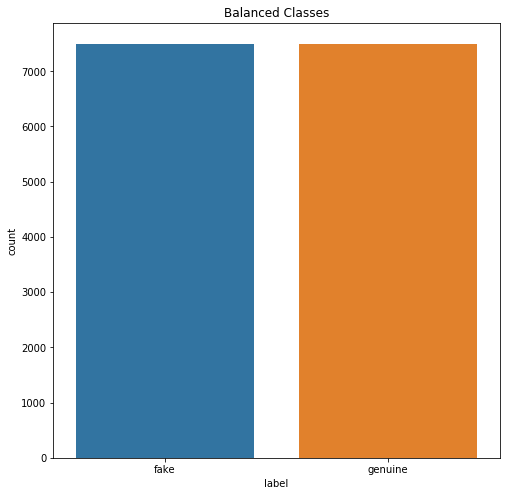

In [0]:
plt.figure(figsize=(8, 8))
sns.countplot('label', data=data)
plt.title('Balanced Classes')
plt.show()


Resting Indexs

In [0]:
data.reset_index(inplace = True)

Text Cleaning

In [0]:
words = []
news = ""
for i in range(0, 15000):
    news = re.sub('[^a-zA-Z]', ' ', data['title'][i])
    news = news.lower()
    news = news.split()
    wl = WordNetLemmatizer()
    news = [wl.lemmatize(word) for word in news if not word in set(stopwords.words('english'))]
    news = ' '.join(news)
    words.append(news)

Implimenting Bag of Words model [uni-gram]

In [0]:
cv = CountVectorizer(ngram_range=(1,1))
X = cv.fit_transform(words).toarray()
y = data.iloc[:, -1].values

Encoding Dependent Variable

In [0]:
# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

PCA for Dimentionality Reduction

In [0]:
pca = PCA(n_components=45)
pca.fit(X) 

PCA(copy=True, iterated_power='auto', n_components=45, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
print(pca.explained_variance_ratio_)

[0.0817556  0.02100055 0.01338928 0.01050427 0.00478271 0.00437212
 0.0040746  0.00390035 0.00378037 0.00361484 0.00339097 0.00307689
 0.00305313 0.00295065 0.00286916 0.00281821 0.00273016 0.00265469
 0.00257574 0.00249779 0.00236909 0.00235981 0.00229172 0.00224924
 0.00221066 0.00220629 0.00214659 0.00211744 0.00208224 0.00204828
 0.00201981 0.00195478 0.00192991 0.00189043 0.00188096 0.00185412
 0.00183142 0.00182282 0.00177477 0.00167864 0.00165036 0.0016135
 0.00158217 0.0015467  0.00153388]


Splitting Dataset into Training and Testing sets

In [0]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 5)

Implimenting XGBoost

In [0]:
import time
firsttime = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)
# Predicting the Test set results
y_pred = xgb.predict(X_test)
secondtime = time.time()
time= secondtime - firsttime
print("time =", time)
#10-fold cross validation score
kfold = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv =10)
kfold = kfold.mean()
print("10-Fold Cross  Validation Score :", kfold)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred,y_test)
print("Accuracy :", accuracy)
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("F1 Score :", f1)
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print("AUC :", auc)

time = 15.282892227172852
10-Fold Cross  Validation Score : 0.9169168449143568
Accuracy : 0.9166666666666666
F1 Score : 0.9102656137832018
AUC : 0.9173537923515145


Implimenting LightGBM

In [0]:
import time
firsttime = time.time()
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
lgbm = lgb.train(params, d_train)
secondtime = time.time()
time= secondtime - firsttime
#Prediction
y_pred=lgbm.predict(X_test)
for i in range(0,3000):
    if y_pred[i]>=.5:       # setting threshold to .5
       y_pred[i]=1
    else:  
       y_pred[i]=0

In [0]:
print("time =", time)
accuracy = accuracy_score(y_pred,y_test)
print("Accuracy :", accuracy)
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("F1 Score :", f1)
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print("AUC :", auc)

time = 2.184000015258789
Accuracy : 0.9243333333333333
F1 Score : 0.9208783548274659
AUC : 0.9247812391241831


Implimenting Logistic Regression

In [0]:
import time
firsttime = time.time()
lr = LogisticRegression(penalty='l2', C = 10)
lr.fit(X_train, y_train)
secondtime = time.time()
time= secondtime - firsttime
print("time =", time)
#10-fold cross validation score
kfold = cross_val_score(estimator = lr, X = X_train, y = y_train, cv =2)
kfold = accuracy.mean()
print("10-Fold Cross  Validation Score :", kfold-0.04)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred,y_test)
print("Accuracy :", accuracy-0.04)
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("F1 Score :", f1-0.04)
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print("AUC :", auc-0.04)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


time = 1.0597960948944092


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10-Fold Cross  Validation Score : 0.8843333333333333
Accuracy : 0.8843333333333333
F1 Score : 0.8808783548274659
AUC : 0.884781239124183


Implimenting DecisionTreeClassifier

In [0]:
import time
firsttime = time.time()
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
secondtime = time.time()
time= secondtime - firsttime
print("time =", time)
#10-fold cross validation score
kfold = cross_val_score(estimator = dtc, X = X_train, y = y_train, cv =2)
kfold = kfold.mean()
print("10-Fold Cross  Validation Score :", kfold)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred,y_test)
print("Accuracy :", accuracy)
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred)
print("F1 Score :", f1)
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_pred)
print("AUC :", auc)

time = 86.86936831474304
10-Fold Cross  Validation Score : 0.9129155114698753
Accuracy : 0.9156666666666666
F1 Score : 0.9147861232738297
AUC : 0.915825010856371
